# Is there a difference of transaction values between even hours and odd hours?
Ref: 
- http://nipper.work/btc/index.php?market=bitFlyer&coin=BTCJPY&periods=3600&after=1643673600&before=1651276800
- https://github.com/just4jc/DataCamp-3/blob/master/07-statistical-thinking-in-python-(part-2)/3-introduction-to-hypothesis-testing/permutation-test-on-frog-data.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
!pip install scipy==1.7.0
from scipy import stats

pd.options.display.float_format = '{:,.2f}'.format
path = "/content/drive/MyDrive/ds_portfolio/btc_transactions_record/data"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_csv(path + "/01_raw/btc_202202_202204_per1h.csv", header=None, names=["datetime", "open", "close", "low", "high", "volumes"], parse_dates=['datetime'])

In [3]:
df["vol_prices"] = df["volumes"] * (df["low"] + df["high"])/2

In [4]:
even_hours_arr = df[df["datetime"].dt.hour %2 == 0]["vol_prices"].values
odd_hours_arr = df[df["datetime"].dt.hour %2 != 0]["vol_prices"].values

In [5]:
print(f"Even hours transaction values: {np.mean(even_hours_arr)}, Odd hours transaction values: {np.mean(odd_hours_arr)}")

Even hours transaction values: 426468452.5181407, Odd hours transaction values: 439551281.04645884


From the above comparisons, the mean of odd hours transaction values is a bit larger than that of even hours transaction values?

## Check the distributions

In [20]:
df[["datetime", "vol_prices"]]

,datetime,vol_prices
0,2022-02-01 00:00:00,"242,793,218.58"
1,2022-02-01 01:00:00,"459,916,657.73"
2,2022-02-01 02:00:00,"410,798,211.18"
3,2022-02-01 03:00:00,"374,209,930.84"
4,2022-02-01 04:00:00,"373,332,314.92"
...,...,...
2108,2022-04-29 20:00:00,"430,320,624.13"
2109,2022-04-29 21:00:00,"258,360,421.30"
2110,2022-04-29 22:00:00,"225,163,858.92"
2111,2022-04-29 23:00:00,"208,232,636.47"


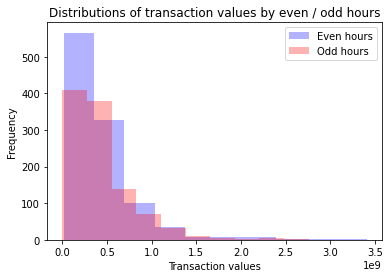

In [6]:
fig, ax1 = plt.subplots()

ax1.hist(even_hours_arr, color="b", alpha=0.3)
ax1.hist(odd_hours_arr, color="r", alpha=0.3)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of transaction values by even / odd hours")
ax1.legend(["Even hours", "Odd hours"]);

It seems tough to compare the distributions by eyeballs.

In [16]:
# Method 2
## From the both sample distributions, choose 1000 sub-samples randomly and take its mean and iterate this process 10000 times.

sample_means_even_hours = [np.mean(random.choices(even_hours_arr, k=10000)) for i in range(10000)] 
sample_means_odd_hours = [np.mean(random.choices(odd_hours_arr, k=10000)) for i in range(10000)]

In [17]:
print(f"Sample means of even hours transaction values: {np.mean(sample_means_even_hours)}, Sample means of odd hours transaction values: {np.mean(sample_means_odd_hours)}")

Sample means of even hours transaction values: 426520359.88023907, Sample means of odd hours transaction values: 439507036.824851


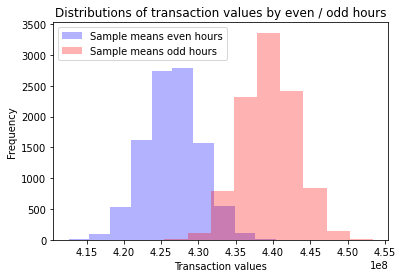

In [18]:
fig, ax1 = plt.subplots()

ax1.hist(sample_means_even_hours, color="b", alpha=0.3)
ax1.hist(sample_means_odd_hours, color="r", alpha=0.3)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of transaction values by even / odd hours")
ax1.legend(["Sample means even hours", "Sample means odd hours"]);

## Conduct permutation test on the two series: Even hours and Odd hours
- H0: Odd hours transaction values == Even hours transaction values
- H1: Odd hours transaction values > Even hours transaction values

In [16]:
def permutate_sample(s1, s2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: concat
    concat = np.concatenate((s1, s2))

    # Permute the concatenated array: permuted
    permuted = np.random.permutation(concat)

    # Split the permuted array into two: perm1, perm2
    perm1 = permuted[:len(s1)]
    perm2 = permuted[len(s1):]

    return perm1, perm2

def draw_perm_reps(s1, s2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_reps = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm1, perm2 = permutate_sample(s1, s2)

        # Compute the test statistic
        perm_reps[i] = func(perm1, perm2)

    return perm_reps

def diff_of_means(s1, s2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(s1) - np.mean(s2)

    return diff

p-value = 0.2021
13082828.528318167


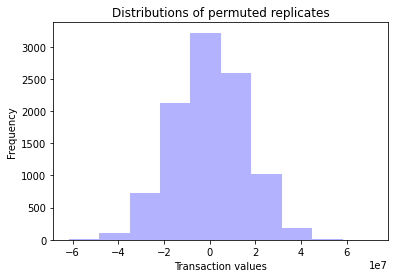

In [17]:
# Method 1

# Compute difference of mean transaction values: actual_diff_means
actual_diff_means = diff_of_means(odd_hours_arr, even_hours_arr)

# Draw 10,000 permutation replicates: perm_reps
perm_reps = draw_perm_reps(odd_hours_arr, even_hours_arr,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_reps >= actual_diff_means) / len(perm_reps)

# Print the result
print('p-value =', p)

fig, ax1 = plt.subplots()

ax1.hist(perm_reps, color="b", alpha=0.3)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of permuted replicates");
print(actual_diff_means)

p-value = 0.0
13057811.009578526


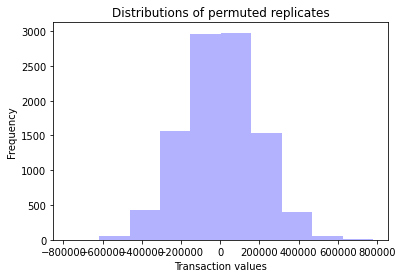

In [18]:
# Method 2

# Compute difference of mean transaction values: actual_diff_means
actual_diff_means = diff_of_means(sample_means_odd_hours, sample_means_even_hours)

# Draw 10,000 permutation replicates: perm_reps
perm_reps = draw_perm_reps(sample_means_odd_hours, sample_means_even_hours,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_reps >= actual_diff_means) / len(perm_reps)

# Print the result
print('p-value =', p)

fig, ax1 = plt.subplots()

ax1.hist(perm_reps, color="b", alpha=0.3)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of permuted replicates");
print(actual_diff_means)

## 2標本t検定 (Welch検定)

In [15]:
# Method 1
stats.ttest_ind(odd_hours_arr, even_hours_arr, equal_var = False, alternative = "greater")

Ttest_indResult(statistic=0.8317872077616754, pvalue=0.202811571936252)

In [20]:
# Method 2
stats.ttest_ind(sample_means_odd_hours, sample_means_even_hours, equal_var = False, alternative = "greater")

Ttest_indResult(statistic=80.64550084060814, pvalue=0.0)

## Conclusion: 
Transaction values during Odd hours are not larger than those of Even hours statistically significantly at the 0.1 significance level. 

Therefore, we accept H0.